# Accessibility descriptive analysis and modeling

In [6]:
%load_ext autoreload
%autoreload 2
%cd D:\netmob25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
D:\netmob25


In [14]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM, s, f
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import matplotlib as mpl
def setup_mpl():
    mpl.rc('font', size = 9)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.minor.width'] = 1
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 1
    mpl.rcParams['xtick.top'] = False
    mpl.rcParams['ytick.right'] = False
    mpl.rcParams['mathtext.default'] = 'regular'
    mpl.rcParams['xtick.major.pad'] = '2.3'
    mpl.rcParams['ytick.major.pad' ]= '2.3'
    mpl.rcParams['axes.labelpad'] = 2

setup_mpl()

In [4]:
df = pd.read_parquet("dbs/activity_access.parquet")
df.loc[:, 'Home'] = df['purpose'] == 'Home'
df.columns

Index(['lon', 'lat', 'time', 'day_type', 'dow', 'ID', 'purpose', 'weight_day',
       'trip_id', 'hour', 'accessibility', 'time_threshold', 'amenity', 'mode',
       'd2h', 'home_accessibility', 'gap_access', 'Home'],
      dtype='object')

In [ ]:
def wmedian(x, weight_field='weight_day'):
    """
    Weighted median function.
    """
    if len(x) == 0:
        return pd.Series(dict(accessibility=np.nan, d2h=np.nan, mode_main=np.nan))
    d1 = DescrStatsW(x['accessibility'], weights=x[weight_field])
    d2 = DescrStatsW(x['d2h'], weights=x[weight_field])
    return pd.Series(dict(accessibility=d1.quantile(0.5, return_pandas=False)[0], 
                          d2h=d2.quantile(0.5, return_pandas=False)[0]))


In [ ]:
tqdm.pandas()
df_nh = df[~df['Home']].groupby(['ID', 'time_threshold', 'amenity', 'mode']).progress_apply(wmedian).reset_index().rename(columns={'accessibility': 'access_nh', 
                                                                                                                                    'd2h': 'd2h_nh'})
df_h = df[df['Home']].groupby(['ID', 'time_threshold', 'amenity', 'mode']).progress_apply(wmedian).reset_index().rename(columns={'accessibility': 'access_h',
                                                                                                                                 'd2h': 'd2h_h'})
df_ind = pd.merge(df_nh, df_h.drop(columns=['d2h_h']), on=['ID', 'time_threshold', 'amenity', 'mode'], how='left')
df_ind.head()

In [ ]:
df_i = pd.read_csv('dbs/data/individuals_dataset.csv')
df_i = df_i[df_i['ID'].isin(df_ind['ID'].unique())].copy()
df_i = df_i[['ID', 'CODGEO', 'WEIGHT_INDIV']].rename(columns={'CODGEO': 'codgeo', 'WEIGHT_INDIV': 'weight_ind'})
df_ind = df_ind.merge(df_i, on='ID', how='left')

# Get access disparity
df_ind['gap'] = df_ind['access_nh']/df_ind['access_h']
df_ind = df_ind.replace([np.inf, -np.inf], np.nan).dropna()
df_ind = df_ind[df_ind['gap'] > 0]
df_ind.to_parquet("results/activity_access_ind.parquet", index=False)

,ID,time_threshold,amenity,mode,access_nh,d2h_nh,access_h,codgeo,weight_ind
0,10_2978,15 min,Education,Car,255.0,1.964411,323.0,78092,1856.20616
1,10_2978,15 min,Education,Public transit,6.0,1.964411,4.0,78092,1856.20616
2,10_2978,15 min,Essential needs,Car,611.0,1.964411,784.0,78092,1856.20616
3,10_2978,15 min,Essential needs,Public transit,21.0,1.964411,4.0,78092,1856.20616
4,10_2978,15 min,Health services,Car,460.0,1.964411,592.5,78092,1856.20616


In [77]:
df_ind.to_parquet("results/activity_access_ind.parquet", index=False)

## 1. Aggregate at individual home area

In [79]:
def wmedian_area(x, weight_field='weight_day'):
    """
    Weighted median function.
    """
    if len(x) == 0:
        return pd.Series(dict(access_h=np.nan, d2h_nh=np.nan, access_nh=np.nan))
    d1 = DescrStatsW(x['access_h'], weights=x[weight_field])
    d2 = DescrStatsW(x['d2h_nh'], weights=x[weight_field])
    d3 = DescrStatsW(x['access_nh'], weights=x[weight_field])
    return pd.Series(dict(access_h=d1.quantile(0.5, return_pandas=False)[0], 
                          d2h_nh=d2.quantile(0.5, return_pandas=False)[0],
                          access_nh=d3.quantile(0.5, return_pandas=False)[0]))

In [80]:
df_ind = pd.read_parquet("results/activity_access_ind.parquet")
tqdm.pandas()
df_area = df_ind.groupby(['codgeo', 'time_threshold', 'amenity', 'mode']).progress_apply(lambda x: wmedian_area(x, weight_field='weight_ind')).reset_index()
df_area.head()

C:\Users\yuanlia\AppData\Local\Temp\ipykernel_14636\673966993.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area = df_ind.groupby(['codgeo', 'time_threshold', 'amenity', 'mode']).progress_apply(lambda x: wmedian_area(x, weight_field='weight_ind')).reset_index()
100%|██████████| 8868/8868 [00:38<00:00, 232.08it/s]


,codgeo,time_threshold,amenity,mode,access_h,d2h_nh,access_nh
0,75101,15 min,Education,Car,1386.0,1.575827,1447.0
1,75101,15 min,Education,Public transit,126.0,1.575827,84.0
2,75101,15 min,Essential needs,Car,5041.0,1.575827,4239.0
3,75101,15 min,Essential needs,Public transit,628.0,1.575827,312.0
4,75101,15 min,Health services,Car,1981.0,1.575827,2075.0


In [ ]:
gdf = gpd.read_file('dbs/geo/paris_iris.geojson')
gdf = pd.merge(df_area, gdf[['insee_com', 'geometry']], right_on='insee_com', left_on='codgeo', how='left')
gdf.loc[:, 'gap'] = gdf['access_nh'] / gdf['access_h']
gdf.drop_duplicates(subset=['codgeo', 'time_threshold', 'amenity', 'mode'], inplace=True)
gdf.head()

,codgeo,time_threshold,amenity,mode,access_h,d2h_nh,access_nh,insee_com,geometry,gap
0,75101,15 min,Education,Car,1386.0,1.575827,1447.0,75101,"POLYGON ((2.32347 48.86637, 2.32458 48.86795, ...",1.044012
17,75101,15 min,Education,Public transit,126.0,1.575827,84.0,75101,"POLYGON ((2.32347 48.86637, 2.32458 48.86795, ...",0.666667
34,75101,15 min,Essential needs,Car,5041.0,1.575827,4239.0,75101,"POLYGON ((2.32347 48.86637, 2.32458 48.86795, ...",0.840905
51,75101,15 min,Essential needs,Public transit,628.0,1.575827,312.0,75101,"POLYGON ((2.32347 48.86637, 2.32458 48.86795, ...",0.496815
68,75101,15 min,Health services,Car,1981.0,1.575827,2075.0,75101,"POLYGON ((2.32347 48.86637, 2.32458 48.86795, ...",1.047451


In [84]:
gpd.GeoDataFrame(gdf, geometry='geometry').drop(columns=['codgeo']).to_file('results/activity_access_ind_area.gpkg', 
                                                                            driver='GPKG', layer='activity_access_ind_area')

## 2. Distributions - access disparity


In [6]:
def get_bins(data=None, col_name=None, weights=None, bin_num=None, weight_lb=True, log_scale=True):
    lower, upper = min(data[col_name]), max(data[col_name])
    if log_scale:
        bins = np.logspace(np.log(lower), np.log(upper), bin_num)
    else:
        bins = np.linspace(lower, upper, bin_num)
    # Use weights in the histogram calculation
    if weight_lb:
        hist, edges = np.histogram(data[col_name], bins=bins, weights=data[weights], density=True)
    else:
        hist, edges = np.histogram(data[col_name], bins=bins, density=True)
    # Normalize to get fractions (relative frequencies)
    #hist_fraction = hist / hist.sum()
    x = (edges[1:] + edges[:-1]) / 2
    
    xx, yy = zip(*[(i, j) for (i, j) in zip(x, hist) if j > 0])
    return data[col_name].median(), xx, yy


def long_tail_distr(data1=None, x_lb=None, y_lb=None, col_name=None, bin_num=50):
    md_value1, xx1, yy1 = get_bins(data=data1, col_name=col_name, weights='weight_ind', bin_num=bin_num)
    fig, ax = plt.subplots()
    ax.plot(xx1, yy1, marker='.', label='Census')
    plt.axvline(x=md_value1, color='r', linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_lb)
    ax.set_ylabel(y_lb)
    plt.legend()
    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Access gap', ylabel='Probability density'>)

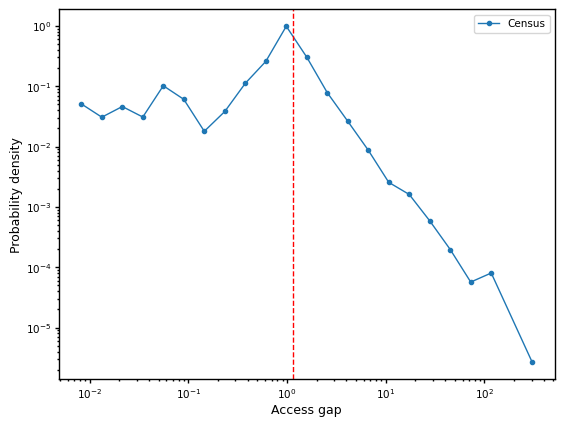

In [68]:
df2plot = df_ind.loc[(df_ind['mode'] == 'Car') & (df_ind['time_threshold'] == '15 min') & (df_ind['amenity'] == 'Essential needs')].copy()
long_tail_distr(data1=df2plot.dropna(), x_lb='Access gap', y_lb='Probability density', col_name='gap', bin_num=50)

In [4]:
df_ind = pd.read_parquet("results/activity_access_ind.parquet")

### 2.1 Data generation (access gap)

In [74]:
plot_df_list = []
for name, group in df_ind.groupby(['mode', 'time_threshold', 'amenity']):
    _, x, y = get_bins(data=group, col_name='gap', weights='weight_ind', bin_num=50)
    temp = pd.DataFrame()
    temp['x'] = x
    temp['y'] = y
    for var, n in zip(['mode', 'time_threshold', 'amenity'], name):
        temp[var] = n
    plot_df_list.append(temp)
df2plot = pd.concat(plot_df_list)

C:\Users\yuanlia\AppData\Local\Temp\ipykernel_14636\1193176171.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_ind.groupby(['mode', 'time_threshold', 'amenity']):


In [76]:
df2plot.to_parquet('results/activity_access_ind_distr.parquet', index=False)

### 2.2 Data generation (access home)

In [8]:
plot_df_list = []
for name, group in df_ind.groupby(['mode', 'time_threshold', 'amenity']):
    _, x, y = get_bins(data=group, col_name='access_h', weights='weight_ind', bin_num=50)
    temp = pd.DataFrame()
    temp['x'] = x
    temp['y'] = y
    for var, n in zip(['mode', 'time_threshold', 'amenity'], name):
        temp[var] = n
    plot_df_list.append(temp)
df2plot = pd.concat(plot_df_list)
df2plot.to_parquet('results/activity_access_h_ind_distr.parquet', index=False)

C:\Users\yuanlia\AppData\Local\Temp\ipykernel_10280\388665411.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_ind.groupby(['mode', 'time_threshold', 'amenity']):


## 3. Modeling - predict access disparity
### 3.1 Individual preparation

In [60]:
df = pd.read_parquet("results/activity_access_ind.parquet")
df_i = pd.read_csv('dbs/data/individuals_dataset.csv')
df_i = df_i[df_i['ID'].isin(df['ID'].unique())].copy()
print(df_i.columns)
df_i = df_i[['ID', 'SEX', 'AGE', 'DIPLOMA', 'TYPE_HOUSE', 'NB_CAR', 
             'BIKE', 'TWO_WHEELER', 'ELECT_SCOOTER', 
             'NAVIGO_SUB', 'IMAGINER_SUB', 'OTHER_SUB_PT', 'BIKE_SUB', 'NSM_SUB', 
             'WEIGHT_INDIV']]

Index(['ID', 'CODGEO', 'AREA_NAME', 'SEX', 'AGE', 'DIPLOMA', 'PRO_CAT',
       'TYPE_HOUSE', 'NBPERS_HOUSE', 'NB_10', 'NB_11_17', 'NB_18_24',
       'NB_25_64', 'NB_65', 'PMR', 'DRIVING_LICENCE', 'NB_CAR', 'TWO_WHEELER',
       'BIKE', 'ELECT_SCOOTER', 'NAVIGO_SUB', 'IMAGINER_SUB', 'OTHER_SUB_PT',
       'BIKE_SUB', 'NSM_SUB', 'WEIGHT_INDIV', 'GPS_RECORD'],
      dtype='object')


#### Diploma

In [61]:
# Process diploma distribution
diploma_dist = (
    df_i.groupby("DIPLOMA")["WEIGHT_INDIV"]
    .sum()
    .sort_values(ascending=False)
)

# Compute cumulative share
diploma_cumshare = (
    diploma_dist / diploma_dist.sum()
).cumsum()

# Combine both counts and cumulative share into one DataFrame
diploma_summary = pd.DataFrame({
    "count": diploma_dist,
    "cumulative_share": diploma_cumshare
})

print(df_i['DIPLOMA'].unique())
print(diploma_summary)

diploma_order = {
    'No diploma': 0,
    'Vocational certificate (CAP, BEP) or equivalent': 1,
    'Lower secondary certificate (Brevet) or equivalent': 2,
    'Upper secondary diploma (Baccalauréat) or equivalent': 3,
    '3–4-year higher education degree: Licence, Professional Licence, Master 1, or equivalent': 4,
    "5-year-and-above higher education degree: Master's 2, DEA, DESS, Grande École Diploma, Doctorate, etc.": 5
}   # Missing values set to 9


[nan
 "5-year-and-above higher education degree: Master's 2, DEA, DESS, Grande École Diploma, Doctorate, etc."
 '3–4-year higher education degree: Licence, Professional Licence, Master 1, or equivalent'
 'Lower secondary certificate (Brevet) or equivalent'
 'Upper secondary diploma (Baccalauréat) or equivalent'
 'Vocational certificate (CAP, BEP) or equivalent' 'No diploma']
                                                           count  \
DIPLOMA                                                            
Upper secondary diploma (Baccalauréat) or equiv...  3.096732e+06   
5-year-and-above higher education degree: Maste...  1.842296e+06   
3–4-year higher education degree: Licence, Prof...  1.232806e+06   
Vocational certificate (CAP, BEP) or equivalent     1.083715e+06   
Lower secondary certificate (Brevet) or equivalent  6.407201e+05   
No diploma                                          1.868750e+05   

                                                    cumulative_share  
DIPLOM

#### House type

In [62]:
print(df_i['TYPE_HOUSE'].unique())

household_order = {
    'Living alone': 0,
    'In a couple without children': 1,
    'Single parent (divorced / separated / widowed)': 2,
    'Living with one or both parents': 3,
    'Not related to other household members': 4,
    'In a shared apartment (flat-sharing)': 5,
    'In a couple with child(ren)': 6,
    'Another family member in the household': 7
}

['In a couple with child(ren)' 'Living alone'
 'In a couple without children'
 'Single parent (divorced / separated / widowed)'
 'Living with one or both parents'
 'Another family member in the household'
 'Not related to other household members'
 'In a shared apartment (flat-sharing)']


#### No. of mobility equipment

In [63]:
df_i['BIKE'].unique(), df_i['TWO_WHEELER'].unique(), df_i['ELECT_SCOOTER'].unique()

(array(['2', '0', '1', '3', '4+'], dtype=object),
 array(['1', '0', '2', '3', '4+'], dtype=object),
 array(['0', '1', '2', '3', '4+'], dtype=object))

#### Public transit subscription

In [64]:
for var in ['NAVIGO_SUB', 'IMAGINER_SUB', 'OTHER_SUB_PT', 'BIKE_SUB', 'NSM_SUB']:
    print(df_i[var].unique())

[False True nan]
[False  True]
[False  True]
[False  True]
[False  True]


In [65]:
subs = ['NAVIGO_SUB', 'IMAGINER_SUB', 'OTHER_SUB_PT', 'BIKE_SUB', 'NSM_SUB']

# Set pt_sub to True if any of the listed variables are True (ignoring NaNs)
df_i['pt_sub'] = df_i[subs].fillna(False).any(axis=1)

C:\Users\yuanlia\AppData\Local\Temp\ipykernel_11196\1514852913.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_i['pt_sub'] = df_i[subs].fillna(False).any(axis=1)


In [66]:
df_i = df_i[['ID', 'SEX', 'AGE', 'DIPLOMA', 'TYPE_HOUSE', 'NB_CAR', 
             'BIKE', 'TWO_WHEELER', 'ELECT_SCOOTER', 
             'pt_sub']]
df_i.rename(columns={'SEX': 'Gender', 
                     'AGE': 'Age', 
                     'DIPLOMA': 'Education', 
                     'TYPE_HOUSE': 'Household_type', 
                     'NB_CAR': 'Car_no', 
                     'BIKE': 'Bike_no', 
                     'TWO_WHEELER': 'Two_wheeler_no',
                     'ELECT_SCOOTER': 'Escooter_no'}, inplace=True)
df_i.columns

Index(['ID', 'Gender', 'Age', 'Education', 'Household_type', 'Car_no',
       'Bike_no', 'Two_wheeler_no', 'Escooter_no', 'pt_sub'],
      dtype='object')

In [67]:
df_i['Education'] = df_i['Education'].map(diploma_order)
df_i['Education'] = df_i['Education'].fillna(9)
df_i['Household_type'] = df_i['Household_type'].map(household_order)
df_i.head()

,ID,Gender,Age,Education,Household_type,Car_no,Bike_no,Two_wheeler_no,Escooter_no,pt_sub
0,10_2978,Woman,41,9.0,6,2,2,1,0,False
1,10_2980,Man,30,5.0,0,0,0,0,0,True
2,10_2981,Man,38,5.0,1,1,1,0,0,True
3,10_2982,Man,43,4.0,2,1,2,0,0,True
4,10_2984,Woman,39,5.0,0,1,1,0,0,True


In [68]:
df = pd.merge(df, df_i, on='ID', how='left')
df.head()

,ID,time_threshold,amenity,mode,access_nh,d2h_nh,access_h,codgeo,weight_ind,gap,Gender,Age,Education,Household_type,Car_no,Bike_no,Two_wheeler_no,Escooter_no,pt_sub
0,10_2978,15 min,Education,Car,255.0,1.964411,323.0,78092,1856.20616,0.789474,Woman,41,9.0,6,2,2,1,0,False
1,10_2978,15 min,Education,Public transit,6.0,1.964411,4.0,78092,1856.20616,1.500000,Woman,41,9.0,6,2,2,1,0,False
2,10_2978,15 min,Essential needs,Car,611.0,1.964411,784.0,78092,1856.20616,0.779337,Woman,41,9.0,6,2,2,1,0,False
3,10_2978,15 min,Essential needs,Public transit,21.0,1.964411,4.0,78092,1856.20616,5.250000,Woman,41,9.0,6,2,2,1,0,False
4,10_2978,15 min,Health services,Car,460.0,1.964411,592.5,78092,1856.20616,0.776371,Woman,41,9.0,6,2,2,1,0,False


In [75]:
df.to_parquet('results/activity_access_ind_model.parquet', index=False)

## 4. Add individuals' main mode used to modeling data

In [9]:
df = pd.read_parquet('results/activity_access_ind_model.parquet')
df_trips = pd.read_csv("dbs/data/trips_dataset.csv")
print(df_trips.columns)

Index(['KEY', 'ID', 'Day_EMG', 'Date_EMG', 'Day_Type', 'ID_Trip_Days',
       'Type_Trip_OD', 'Area_O', 'Area_D', 'Code_INSEE_O', 'Code_INSEE_D',
       'Zone_O', 'Zone_D', 'Date_O', 'Time_O', 'Date_D', 'Time_D', 'Duration',
       'Purpose_O', 'Purpose_D', 'Main_Mode', 'Mode_1', 'Mode_2', 'Mode_3',
       'Mode_4', 'Mode_5', 'Weight_Day'],
      dtype='object')


In [12]:
# Group by ID and Main_Mode, then sum the weights
mode_weights = df_trips.groupby(['ID', 'Main_Mode'])['Weight_Day'].sum().reset_index()

# For each ID, select the Main_Mode with the highest total weight
most_weighted_mode = mode_weights.loc[mode_weights.groupby('ID')['Weight_Day'].idxmax()].reset_index(drop=True)
most_weighted_mode.head()

,ID,Main_Mode,Weight_Day
0,10_2978,WALKING,2531.296286
1,10_2980,WALKING,2619.288603
2,10_2981,WALKING,2121.667883
3,10_2982,PRIV_CAR_DRIVER,747.887244
4,10_2984,PRIV_CAR_DRIVER,1989.398687


C:\Users\yuanlia\AppData\Local\Temp\ipykernel_11100\2907983828.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mode_counts, x='Main_Mode', y='Frequency', palette='viridis')


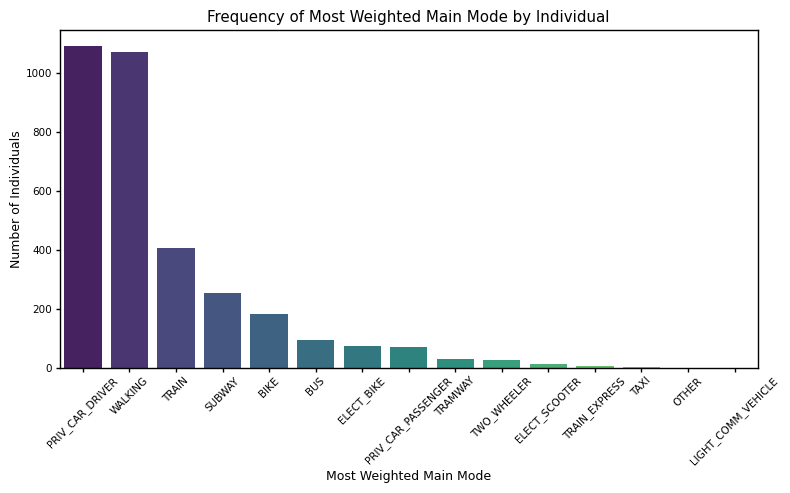

In [15]:
# Count frequency of each Main_Mode
mode_counts = most_weighted_mode['Main_Mode'].value_counts().reset_index()
mode_counts.columns = ['Main_Mode', 'Frequency']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=mode_counts, x='Main_Mode', y='Frequency', palette='viridis')
plt.xlabel('Most Weighted Main Mode')
plt.ylabel('Number of Individuals')
plt.title('Frequency of Most Weighted Main Mode by Individual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
print(most_weighted_mode.Main_Mode.unique())
mode_simplify_dict = {'WALKING': 'Active',
                      'PRIV_CAR_DRIVER': 'Private car (driver)',
                      'BUS': 'Public transit',
                      'SUBWAY': 'Public transit',
                      'TRAIN': 'Public transit',
                      'ELECT_BIKE': 'Micro',
                      'TRAMWAY': 'Public transit',
                      'BIKE': 'Active',
                      'PRIV_CAR_PASSENGER': 'Private car (passenger)',
                      'OTHER': 'Other',
                      'TRAIN_EXPRESS': 'Public transit',
                      'ELECT_SCOOTER': 'Micro',
                      'TWO_WHEELER': 'Micro',
                      'TAXI': 'Taxi',
                      'LIGHT_COMM_VEHICLE': 'Other'}
most_weighted_mode['main_mode'] = most_weighted_mode['Main_Mode'].map(mode_simplify_dict)
most_weighted_mode['main_mode'].unique()

['WALKING' 'PRIV_CAR_DRIVER' 'BUS' 'SUBWAY' 'TRAIN' 'ELECT_BIKE' 'TRAMWAY'
 'BIKE' 'PRIV_CAR_PASSENGER' 'OTHER' 'TRAIN_EXPRESS' 'ELECT_SCOOTER'
 'TWO_WHEELER' 'TAXI' 'LIGHT_COMM_VEHICLE']


array(['Active', 'Private car (driver)', 'Public transit', 'Micro',
       'Private car (passenger)', 'Other', 'Taxi'], dtype=object)

In [20]:
df = pd.merge(df, most_weighted_mode[['ID', 'main_mode']], how='left')
df['main_mode'].unique()

array(['Active', 'Private car (driver)', 'Public transit', 'Micro',
       'Private car (passenger)', 'Other', 'Taxi'], dtype=object)

In [21]:
df.to_parquet('results/activity_access_ind_model.parquet', index=False)